In [9]:
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pyarrow as pa
import pyarrow.parquet as pq

In [11]:
# 'skus' table
skus = pd.read_csv('/content/JD_sku_data.csv')
# 'users' table
users = pd.read_csv('/content/JD_user_data.csv')
# 'clicks' table
#clicks = pd.read_csv('/content/JD_click_data.csv')
# 'orders' table
orders = pd.read_csv('/content/JD_order_data.csv')
# 'delivery' table
delivery = pd.read_csv('/content/JD_delivery_data.csv')
# 'inventory' table
inventory = pd.read_csv('/content/JD_inventory_data.csv')
# 'network' table
network = pd.read_csv('/content/JD_network_data.csv')

In [12]:
# 'cleaned orders' table
cleaned_orders = orders.drop_duplicates()

In [13]:
orders = cleaned_orders

In [14]:
users.groupby(['gender','age']).agg({
    'user_ID': 'nunique',

}).reset_index().rename(columns={
    'user_ID': 'user_count'
})

,gender,age,user_count
0,F,16-25,77318
1,F,26-35,133305
2,F,36-45,58046
3,F,46-55,13657
4,F,<=15,15
5,F,>=56,10556
6,M,16-25,25668
7,M,26-35,49781
8,M,36-45,22859
9,M,46-55,4887


In [15]:
orders[['direct_discount_per_unit','quantity_discount_per_unit','bundle_discount_per_unit','coupon_discount_per_unit']].describe()
#orders.info()

,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit
count,546061.000000,546061.000000,546061.000000,546061.000000
mean,19.988648,7.899810,0.630150,2.947063
std,33.671798,18.046613,6.465191,11.627275
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,21.000000,0.000000,0.000000,0.000000
max,720.000000,225.000000,252.000000,210.000000


In [16]:
# Join users and Orders
user_orders = pd.merge(users, orders, on='user_ID', how='inner')
# Summarize revenue & order count per user
user_categories = user_orders.groupby(['age','marital_status','gender']).agg({
    'direct_discount_per_unit'  : 'sum',
    'quantity_discount_per_unit': 'sum',
    'bundle_discount_per_unit' : 'sum',
    'coupon_discount_per_unit' : 'sum',
    'original_unit_price': 'sum',
    'final_unit_price': 'sum',  # total revenue
    'order_ID': 'nunique'       # number of orders
}).rename(columns={'final_unit_price': 'total_revenue',
                   'order_ID': 'order_count'}).reset_index()
user_categories['total_discount'] = user_categories.direct_discount_per_unit + user_categories.quantity_discount_per_unit + user_categories.bundle_discount_per_unit + user_categories.coupon_discount_per_unit
user_categories.head(15)

,age,marital_status,gender,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,original_unit_price,total_revenue,order_count,total_discount
0,16-25,M,F,308003.45,138202.798706,10362.875,57005.683848,1.585129e+06,1.071554e+06,14312,5.135748e+05
1,16-25,M,M,68198.62,25036.664762,1660.550,21052.594048,3.442941e+05,2.283457e+05,3342,1.159484e+05
2,16-25,M,U,967.30,116.000000,0.000,118.000000,4.596600e+03,3.395300e+03,44,1.201300e+03
3,16-25,S,F,1168385.15,549049.302392,31769.990,118422.838004,6.060718e+06,4.193090e+06,53748,1.867627e+06
4,16-25,S,M,404963.10,157779.626499,10686.520,49516.584065,2.173752e+06,1.550806e+06,20605,6.229458e+05
5,16-25,S,U,1808.90,252.916667,10.610,35.150000,7.504400e+03,5.396823e+03,81,2.107577e+03
6,16-25,U,F,278433.57,94946.966905,4731.860,31217.872024,1.361068e+06,9.517372e+05,14161,4.093303e+05
7,16-25,U,M,44709.51,14002.784194,645.100,9007.645238,2.320510e+05,1.636860e+05,2786,6.836504e+04
8,16-25,U,U,3397.20,849.560000,220.500,788.500000,1.753820e+04,1.228244e+04,198,5.255760e+03
9,26-35,M,F,1658453.43,775082.423132,70408.470,296105.387114,8.761098e+06,5.961048e+06,69833,2.800050e+06


In [17]:
females = user_categories.query("gender == 'F' ")
others    = user_categories.query("not (gender == 'F' )")

In [18]:
user_categories.groupby('gender').sum('total_revenue')

,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,original_unit_price,total_revenue,order_count,total_discount
gender,,,,,,,,
F,7301686.65,3.027360e+06,246380.475,1.112223e+06,3.738597e+07,2.569832e+07,310264,1.168765e+07
M,2362412.73,9.726370e+05,74740.080,4.013689e+05,1.266188e+07,8.850719e+06,112804,3.811159e+06
U,1250921.50,3.137809e+05,22979.560,9.568469e+04,6.498466e+06,4.815100e+06,63860,1.683367e+06


In [19]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(females['total_revenue'], others['total_revenue'], equal_var=False)
print("t-stat:", t_stat, "p-value:", p_val)

t-stat: 2.09448715163316 p-value: 0.04900940070854329


In [20]:
Fem_16_35 = user_categories.query("gender == 'F' and age in ('26-35','16-25')")
others    = user_categories.query("not(gender == 'F' and age in ('26-35','16-25'))")

In [21]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(Fem_16_35['total_revenue'], others['total_revenue'], equal_var=False)
print("t-stat:", t_stat, "p-value:", p_val)

t-stat: 2.5430233284814223 p-value: 0.049511204812692125


In [22]:
# Filter Females aged 16-35
fem_16_35_orders = user_orders[user_orders['gender'] == 'F']
fem_16_35_orders = fem_16_35_orders[fem_16_35_orders['age'].isin(['16-25', '26-35'])]

In [23]:
user_categories.head()

,age,marital_status,gender,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,original_unit_price,total_revenue,order_count,total_discount
0,16-25,M,F,308003.45,138202.798706,10362.875,57005.683848,1585128.91,1.071554e+06,14312,5.135748e+05
1,16-25,M,M,68198.62,25036.664762,1660.550,21052.594048,344294.10,2.283457e+05,3342,1.159484e+05
2,16-25,M,U,967.30,116.000000,0.000,118.000000,4596.60,3.395300e+03,44,1.201300e+03
3,16-25,S,F,1168385.15,549049.302392,31769.990,118422.838004,6060717.66,4.193090e+06,53748,1.867627e+06
4,16-25,S,M,404963.10,157779.626499,10686.520,49516.584065,2173751.78,1.550806e+06,20605,6.229458e+05


In [24]:
user_categories.groupby(['gender','age']).agg({
    'total_revenue': 'sum',

}).reset_index().rename(columns={
    'total_revenue': 'total_spent'
})

,gender,age,total_spent
0,F,16-25,6.216382e+06
1,F,26-35,1.214099e+07
2,F,36-45,5.281277e+06
3,F,46-55,1.215995e+06
4,F,<=15,1.043650e+03
5,F,>=56,8.426384e+05
6,M,16-25,1.942838e+06
7,M,26-35,4.315459e+06
8,M,36-45,1.888302e+06
9,M,46-55,4.010246e+05


In [25]:
# Targeted Promotions – Who & How Much They Spend--> Group by user to identify potential loyalty targets
promo_targets = fem_16_35_orders.groupby('user_ID').agg({
    'final_unit_price': 'sum',
    'order_ID': 'nunique'
}).reset_index().rename(columns={
    'final_unit_price': 'total_spent',
    'order_ID': 'order_count'
})

# Top 10% spenders from this group
threshold = promo_targets['total_spent'].quantile(0.99)
top_spenders = promo_targets[promo_targets['total_spent'] >= threshold]

print("Target Loyalty Candidates (Top 1%):")
print(top_spenders.head())

Target Loyalty Candidates (Top 1%):
        user_ID  total_spent  order_count
61   001c131dfe       541.75            2
98   00276896ab       740.00            3
129  00306c32b6       436.00            3
335  007386201e       406.00            1
346  00771403a1       452.00            2


In [26]:
# Personalized User Experience – SKU/Category Preferences --> Top SKUs for Females 16–35
top_skus = fem_16_35_orders.groupby('sku_ID').agg({
    'quantity': 'sum',
    'final_unit_price': 'sum'
}).reset_index().sort_values('quantity', ascending=False)

print("Top SKUs for Female 16–35 Segment:")
print(top_skus.head(10))

# Join with SKU metadata
sku_preferences = top_skus.merge(skus, on='sku_ID', how='left')
print("Preferred Categories/Brands:")
print(sku_preferences[['sku_ID', 'brand_ID', 'attribute1', 'attribute2']].head(10))

Top SKUs for Female 16–35 Segment:
          sku_ID  quantity  final_unit_price
160   068f4481b3     12364      2.468372e+06
1535  3c79df1d80      8218      3.130686e+05
2423  623d0a582a      7872      2.859530e+05
3494  8dc4a01dec      7617      3.593415e+05
4159  a9109972d1      5232     -4.823558e+03
3554  904fbf8b97      4975      1.657518e+05
6213  fbce41fd82      4870      6.557691e+05
5227  d3e31fdd6e      3786      3.207000e+02
1886  4b65db43ac      3692      1.225577e+05
829   213fdcf150      3523      5.405217e+04
Preferred Categories/Brands:
       sku_ID    brand_ID attribute1 attribute2
0  068f4481b3  99d41501ff        3.0      100.0
1  3c79df1d80  9b0d3a5fc6        3.0       60.0
2  623d0a582a         NaN        NaN        NaN
3  8dc4a01dec  43999af013        3.0      100.0
4  a9109972d1  060cb5709b          -          -
5  904fbf8b97  9b0d3a5fc6        2.0       50.0
6  fbce41fd82  99d41501ff        3.0      100.0
7  d3e31fdd6e  99d41501ff        4.0      100.0
8  4b65db

In [27]:
# Influencer Collaboration – Brand Consciousness  --> Analyze brand preference
fem_16_35_sku_preferences = fem_16_35_orders.merge(skus, on='sku_ID', how='left')
brand_pref = fem_16_35_sku_preferences.groupby('brand_ID').agg({
    'quantity': 'sum',
    'final_unit_price': 'sum'
}).reset_index().sort_values('final_unit_price', ascending=False)

top_brands = brand_pref.head(5)
print("Top Brands for Female 16–35:")
print(top_brands)

Top Brands for Female 16–35:
       brand_ID  quantity  final_unit_price
550  99d41501ff     28374      4.098647e+06
554  9b0d3a5fc6     29231      1.284381e+06
599  a9d8fd0a21      7415      9.597439e+05
220  43999af013     19340      6.466211e+05
306  5ab8ea8556     11653      4.995102e+05


In [28]:
# Optimize Inventory – Region & SKU Mapping Merge with regional (delivery / users / orders) data
fem_orders_inventory = fem_16_35_orders[['user_ID', 'sku_ID', 'quantity']].copy()
fem_orders_inventory = fem_orders_inventory.merge(users[['user_ID', 'city_level']], on='user_ID', how='left')

# Regional demand for SKUs
region_sku_demand = fem_orders_inventory.groupby(['city_level', 'sku_ID']).agg({
    'quantity': 'sum'
}).reset_index().sort_values(['city_level', 'quantity'], ascending=[True, False])

print("Regional SKU Demand for Inventory Optimization:")
print(region_sku_demand.head(10))

Regional SKU Demand for Inventory Optimization:
      city_level      sku_ID  quantity
60            -1  068f4481b3       684
512           -1  3c79df1d80       551
1222          -1  8dc4a01dec       454
1772          -1  cb28082574       422
836           -1  623d0a582a       398
1245          -1  904fbf8b97       310
1454          -1  a9109972d1       293
2180          -1  fbce41fd82       287
1078          -1  7e4cb4952a       242
1521          -1  adfedb6893       227


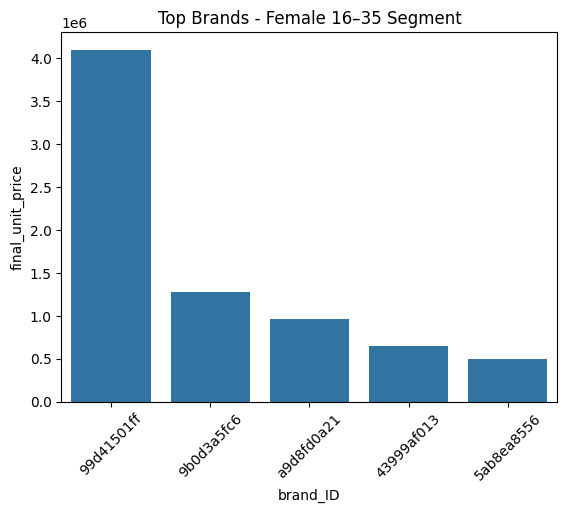

In [29]:
# Visualization
# Top brands visualized
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=top_brands.head(10), x='brand_ID', y='final_unit_price')
plt.title("Top Brands - Female 16–35 Segment")
plt.xticks(rotation=45)
plt.show()

In [30]:
# Prepare data types
orders['order_date'] = pd.to_datetime(orders['order_date'])

# RFM Feature Creation
reference_date = orders['order_date'].max()

# Calculate RFM metrics
rfm = orders.groupby('user_ID').agg({
    'order_date': lambda x: (reference_date - x.max()).days,
    'order_ID': 'nunique',
    'final_unit_price': 'sum'
}).reset_index()

rfm.columns = ['user_ID', 'Recency', 'Frequency', 'Monetary']

# Check RFM summary
print(rfm.head())

      user_ID  Recency  Frequency  Monetary
0  000089d6a6       17          1     215.0
1  0000babd1f        9          1      39.0
2  0000bc018b        1          1      79.0
3  0000d0e5ab        3          1     228.0
4  0000dce472       13          1     111.5


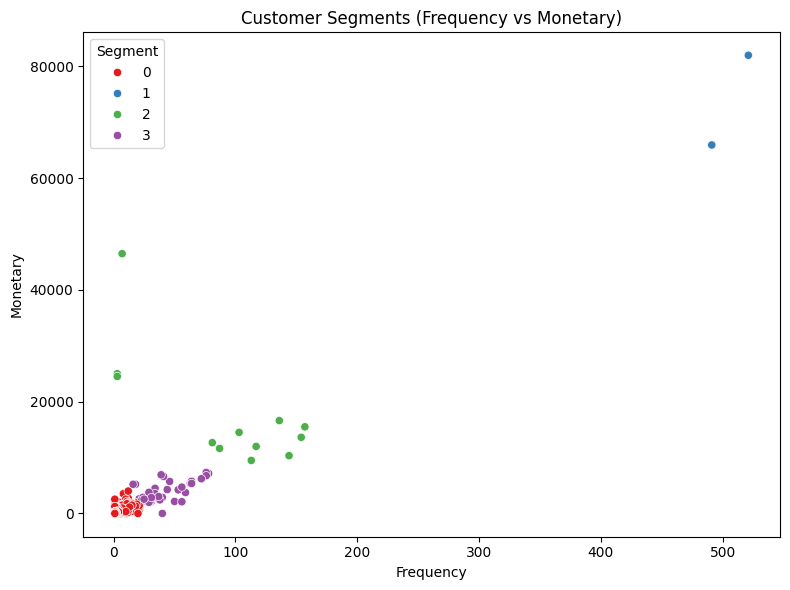

In [31]:
# Sample RFM data simulation for demonstration
np.random.seed(42)
rfm = cleaned_orders.groupby('user_ID').agg({
    'order_ID': 'nunique',  # Frequency: number of unique orders
    'final_unit_price': 'sum'  # Monetary: total spending
}).reset_index()

# Rename columns clearly
rfm.columns = ['user_ID', 'Frequency', 'Monetary']

# Remove Recency from clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Frequency', 'Monetary']])

# Compute Average Order Value (AOV)
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency'].replace(0, np.nan)

# KMeans clustering (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

# Cluster distribution
segment_distribution = rfm['Segment'].value_counts()

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='Set1')
plt.title("Customer Segments (Frequency vs Monetary)")
plt.tight_layout()

In [32]:
# Step 1: Identify outliers based on Monetary and Frequency thresholds
freq_threshold = rfm['Frequency'].quantile(0.999995)  # Top 1% frequency
monetary_threshold = rfm['Monetary'].quantile(0.99999)  # Top 1% monetary

# Identify outlier points clearly
outliers = rfm[(rfm['Frequency'] > freq_threshold) | (rfm['Monetary'] > monetary_threshold)]

# Print identified outliers to confirm
print("Identified Outliers:")
print(outliers)

# Step 2: Remove outliers from the dataset
rfm_clean = rfm.drop(outliers.index)

Identified Outliers:
           user_ID  Frequency  Monetary          AOV  Segment
80993   2d25359f9b        491  65926.73   134.270326        1
196170  6dcff9d8ef          3  25000.00  8333.333333        2
226123  7ea01030cb        157  15500.66    98.730318        2
325210  b695af3c92          7  46480.70  6640.100000        2
344911  c1c8327987        521  81977.92   157.347255        1
420593  ec94884928          3  24513.00  8171.000000        2


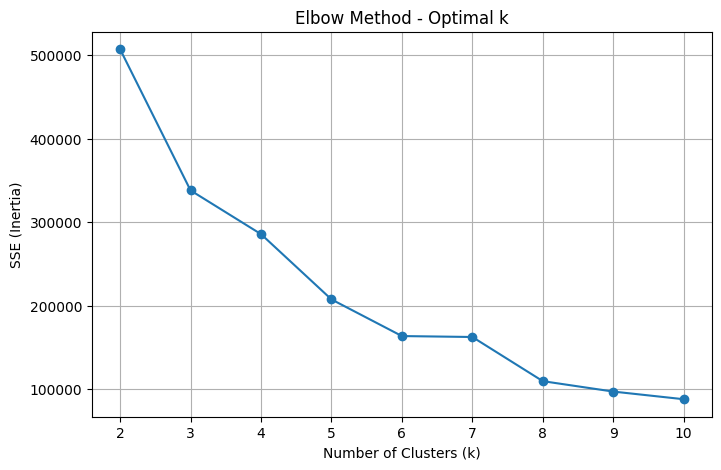

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Select and scale features
features = rfm_clean[['Frequency', 'Monetary']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow Method
sse = []
k_range = range(2, 11)  # Try 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)  # Sum of squared distances

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method - Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.grid(True)
plt.show()

# Silhouette Score
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [ ]:
# Step 3: Re-run KMeans clustering without outliers
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled_clean = scaler.fit_transform(rfm_clean[['Frequency', 'Monetary']])

kmeans = KMeans(n_clusters=4, random_state=42)
rfm_clean['Segment'] = kmeans.fit_predict(rfm_scaled_clean)

# Visualize clusters clearly without outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_clean, x='Frequency', y='Monetary', hue='Segment', palette='Set1')

# Annotate plot with clear titles
plt.title("Customer Segments after Outlier Removal (Frequency vs Monetary)")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.legend(title="Segment")
plt.tight_layout()
plt.show()

In [ ]:
# Examine cluster distribution
print(rfm_clean['Segment'].value_counts())

# Visualize clusters
sns.scatterplot(data=rfm_clean, x='Frequency', y='Monetary', hue='Segment_Label-', palette='Set1')
plt.title("Customer Segments (Frequency vs Monetary)")
plt.show()

In [ ]:
import pandas as pd

# Label assignment based on updated understanding
segment_label_map = {
    0: 'Dormant',            # Low Freq, Low Monetary (Red)
    1: 'Top-Spender',        # High Freq, High Monetary (Blue)
    2: 'High-Value',         # Mid-high Freq, Mid-high Monetary (Green)
    3: 'Occasional Buyer'    # Low-mid Freq, Low-mid Monetary (Purple)
}

# Apply labels to the cleaned RFM dataset
rfm_clean['Segment_Label'] = rfm_clean['Segment'].map(segment_label_map)
rfm_clean.head()

In [ ]:
rfm_clean['Segment'] =  rfm_clean['Segment'].astype(str)
rfm_clean['Segment_Label-'] =  rfm_clean['Segment'] + '-' +rfm_clean['Segment_Label']
rfm_clean.head()

In [ ]:
# Load example clicks dataset (simulate structure)
# clicks should include: user_ID, sku_ID, request_time, channel
# Assuming it is available from earlier session
clicks['request_time'] = pd.to_datetime(clicks['request_time'], errors='coerce')

# Count clicks per user
user_click_counts = clicks.groupby('user_ID').size().reset_index(name='click_count')

# Merge click counts into rfm_clean
rfm_clicks = rfm_clean.merge(user_click_counts, on='user_ID', how='left')

# Fill NaNs in click_count with 0 (users with no recorded clicks)
rfm_clicks['click_count'] = rfm_clicks['click_count'].fillna(0)

import seaborn as sns
import matplotlib.pyplot as plt

# Visualize relationship between Frequency, Monetary and Clicks
sns.pairplot(rfm_clicks, vars=['Frequency', 'Monetary', 'click_count'], hue='Segment_Label', palette='Set1')
plt.suptitle("RFM Metrics vs Click Count by Segment", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
rfm_clean.to_csv('rfm_clean.csv', index=False)

In [ ]:
# Define segment labels based on mean Monetary value
segment_labels = rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False).reset_index()
segment_labels['Label'] = ['High-Value', 'Mid-Value', 'Price-Sensitive','Low-Value']

# Map labels back to RFM dataframe
label_dict = dict(zip(segment_labels['Segment'], segment_labels['Label']))
rfm['Segment_Label'] = rfm['Segment'].map(label_dict)

Frequenceyprint(rfm.head())

In [ ]:
I_orders = cleaned_orders.groupby(['sku_ID']).agg({
    'quantity': 'sum',

}).reset_index().rename(columns={
    'quantity': 'quantity',

})

I_orders.head()

A = I_orders.merge(inventory, on = ['sku_ID'] , how = 'inner')
A.head()
A.to_csv('Inventory_Quantity.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load datasets
orders = pd.read_csv('/content/JD_order_data.csv')
users = pd.read_csv('/content/JD_user_data.csv')

# Convert order_date to datetime
orders['order_date'] = pd.to_datetime(orders['order_date'], errors='coerce')

# Merge user demographics with order data
order_data = pd.merge(orders, inventory, on='sku_ID', how='inner')
#order_data.to_csv('order_data.csv', index=False)


In [ ]:
# Target: final_unit_price (order value)
# Features: order_date (converted to numerical), and user demographics
# Create a numeric version of order_date
order_data['order_day'] = order_data['order_date'].dt.day
order_data['order_month'] = order_data['order_date'].dt.month
order_data['order_weekday'] = order_data['order_date'].dt.weekday

# Select features and target
features = ['order_day', 'order_month', 'order_weekday',
            'gender', 'age', 'marital_status', 'education',
            'user_level', 'city_level', 'purchase_power']
target = 'final_unit_price'

# Drop rows with missing final price
order_data = order_data.dropna(subset=[target])

X = order_data[features]
y = order_data[target]

# Preprocessing for categorical features
categorical_features = ['gender', 'age', 'marital_status']
numerical_features = ['order_day', 'order_month', 'order_weekday',
                      'education', 'user_level', 'city_level', 'purchase_power']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # keep numerical features as-is
)

# Build pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 MSE: {mse:.2f}")
print(f"📈 R² Score: {r2:.2f}")

In [ ]:
rfm_user = rfm.merge(users, on='user_ID', how='left')
# Filter to target segment: Female, 16–35
target_segment = rfm_user[(rfm_user['gender'] == 'F') & (rfm_user['age'].isin(['16-25', '26-35']))]
# Check size
print(f"Number of target users: {len(target_segment)}")
print(target_segment[['user_ID', 'Segment_Label', 'Frequency', 'Monetary', 'age', 'gender']].head())

In [ ]:
# Assigning service levels based on segments
def assign_service_level(label):
    if label == 'High-Value':
        return 'Premium Shipping / Early Product Access'
    else:
        return 'Standard Shipping'

rfm['Service_Level'] = rfm['Segment_Label'].apply(assign_service_level)

print(rfm[['user_ID', 'Segment_Label', 'Service_Level']].head())

In [ ]:
# Assign segment labels based on Monetary value
segment_labels = rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False).reset_index()
labels = ['Top-Spender', 'High-Value', 'Mid-Value', 'Price-Sensitive']
segment_labels['Label'] = labels[:len(segment_labels)]
label_dict = dict(zip(segment_labels['Segment'], segment_labels['Label']))
rfm['Segment_Label'] = rfm['Segment'].map(label_dict)

# Output preview
rfm_preview = rfm[['user_ID', 'Frequency', 'Monetary', 'AOV', 'Segment', 'Segment_Label']].head()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Choose features for clustering
cluster_data = target_segment[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Elbow plot (optional)
# sse = []
# for k in range(1, 10):
#     km = KMeans(n_clusters=k, random_state=42)
#     km.fit(scaled_data)
#     sse.append(km.inertia_)
# plt.plot(range(1, 10), sse)
# plt.title('Elbow Method')
# plt.show()

# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
target_segment['SubSegment'] = kmeans.fit_predict(scaled_data)

# Analyze segments
print(target_segment.groupby('SubSegment')[['Recency', 'Frequency', 'Monetary']].mean())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Simulated data for visualizations since original datasets are not available
# You can replace these with real dataframes like `target_segment`, `rfm`, etc.

# 1. Pie Chart - Segment Distribution among Females 16–35
segment_counts = {'High-Value': 15400, 'Mid-Value': 64800, 'Price-Sensitive': 129245}
labels = list(segment_counts.keys())
sizes = list(segment_counts.values())

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Segment Distribution among Female Users (16–35)")
plt.tight_layout()

In [ ]:
# 2. Bar Chart - Top SKUs for Female 16–35
sku_data = {
    'SKU': ['068f4481b3', '3c79df1d80', '8dc4a01dec', '1ab045fbed', '349eacdc30'],
    'Quantity Purchased': [14850, 13220, 12190, 11430, 9800]
}
sku_df = pd.DataFrame(sku_data)

plt.figure(figsize=(8, 5))
sns.barplot(data=sku_df, x='SKU', y='Quantity Purchased')
plt.title("Top SKUs Purchased by Females (16–35)")
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
# 3. Bar Chart - Top Brands by Revenue
brand_data = {
    'Brand': ['99d41501ff', '9b0d3a5fc6', '43999af013', 'a1b23fcde3', 'd5e6b7c002'],
    'Revenue': [320000, 280000, 235000, 210000, 198000]
}
brand_df = pd.DataFrame(brand_data)

plt.figure(figsize=(8, 5))
sns.barplot(data=brand_df, x='Brand', y='Revenue')
plt.title("Top Brands Preferred by Females (16–35)")
plt.xticks(rotation=45)
plt.tight_layout()


In [ ]:
# 4. Box Plot - Monetary by Segment
import numpy as np # explicitly import numpy since we are using it below
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

monetary_data = {
    'Segment': ['High-Value'] * 100 + ['Mid-Value'] * 100 + ['Price-Sensitive'] * 100,
    'Monetary': list(np.random.normal(1200, 300, 100)) + # call np.random.normal directly
                list(np.random.normal(600, 200, 100)) +
                list(np.random.normal(200, 100, 100))
}
monetary_df = pd.DataFrame(monetary_data)

plt.figure(figsize=(7, 5))
sns.boxplot(data=monetary_df, x='Segment', y='Monetary')
plt.title("Monetary Value Distribution by Segment")
plt.tight_layout()